<a href="https://colab.research.google.com/github/gpang0801/Deep-Learning-Paper-Review-and-Practice/blob/main/code_practices/Attention_is_All_You_Need_Tutorial_(German_English).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **Attention is All You Need (NIPS 2017)** 실습
* 본 코드는 기본적으로 **Transformer** 논문의 내용을 최대한 따릅니다.
    * 본 논문은 **딥러닝 기반의 자연어 처리** 기법의 기본적인 구성을 이해하고 공부하는 데에 도움을 줍니다.
    * 2020년 기준 가장 뛰어난 번역 모델들은 본 논문에서 제안한 **Transformer 기반의 아키텍처**를 따르고 있습니다.
* 코드 실행 전에 **[런타임]** → **[런타임 유형 변경]** → 유형을 **GPU**로 설정합니다.

#### <b>BLEU Score 계산을 위한 라이브러리 업데이트</b>

* <b>[Restart Runtime]</b> 버튼을 눌러 런타임을 재시작할 필요가 있습니다.

In [75]:
!pip install torchtext==0.6.0

#### **데이터 전처리(Preprocessing)**

* **spaCy 라이브러리**: 문장의 토큰화(tokenization), 태깅(tagging) 등의 전처리 기능을 위한 라이브러리
  * 영어(Engilsh)와 독일어(Deutsch) 전처리 모듈 설치

In [76]:
%%capture
!python -m spacy download en
!python -m spacy download de

In [77]:
import spacy

spacy_en = spacy.load("en_core_web_sm") # 영어

spacy_de = spacy.load("de_core_news_sm") # 독일어

In [78]:
# 간단히 토큰화(tokenization) 기능 써보기

tokenized = spacy_en.tokenizer("I am a graduate student.")

for i, token in enumerate(tokenized):
  print(f"인덱스 {i}: {token.text}")

인덱스 0: I
인덱스 1: am
인덱스 2: a
인덱스 3: graduate
인덱스 4: student
인덱스 5: .


* 영어(English) 및 독일어(Deutsch) **토큰화 함수** 정의

In [79]:
# [수정] 토크나이저 함수 자체에서 소문자 처리를 하도록 변경
def tokenize_de(text):
    return [token.text.lower() for token in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [token.text.lower() for token in spacy_en.tokenizer(text)]

In [80]:
!pip install datasets
!pip install portalocker

* **필드(field)** 라이브러리를 이용해 데이터셋에 대한 구체적인 전처리 내용을 명시합니다.
* Seq2Seq 모델과는 다르게 <b>batch_first 속성의 값을 True로 설정</b>합니다.
* 번역 목표
    * 소스(SRC): 독일어
    * 목표(TRG): 영어

In [81]:
from torchtext.data import Field, BucketIterator

SRC = Field(tokenize=tokenize_de, init_token="<sos>", eos_token="<eos>", lower=True, batch_first=True)

TRG = Field(tokenize=tokenize_en, init_token="<sos>", eos_token="<eos>", lower=True, batch_first=True)

* 대표적인 영어-독어 번역 데이터셋인 **Multi30k**를 불러옵니다.

In [82]:
from datasets import load_dataset

# 1. Multi30k 데이터셋 로드 (안정적인 미러 버전)

raw_datasets = load_dataset("bentrevett/multi30k")

# 2. 데이터 확인 (train, validation, test 분할이 이미 되어 있음)

train_dataset = raw_datasets['train']

valid_dataset = raw_datasets['validation']

test_dataset = raw_datasets['test']

# 3. 예시 출력 (독일어 'de', 영어 'en' 쌍)

print(f"첫 번째 데이터: {train_dataset[0]}")

# 결과: {'en': 'Two young, white males are outside near many bushes.', 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'}

첫 번째 데이터: {'en': 'Two young, White males are outside near many bushes.', 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'}


In [83]:
print(f"학습 데이터셋(training dataset) 크기: {len(train_dataset)}개")
print(f"평가 데이터셋(validation dataset) 크기: {len(valid_dataset)}개")
print(f"테스트 데이터셋(testing dataset) 크기: {len(test_dataset)}개")

학습 데이터셋(training dataset) 크기: 29000개
평가 데이터셋(validation dataset) 크기: 1014개
테스트 데이터셋(testing dataset) 크기: 1000개


In [84]:
# 30번째 데이터의 독일어(src)와 영어(trg) 출력
print(train_dataset[30]['de'])
print(train_dataset[30]['en'])

Ein Mann, der mit einer Tasse Kaffee an einem Urinal steht.
A man standing at a urinal with a coffee cup.


* **필드(field)** 객체의 **build_vocab** 메서드를 이용해 영어와 독어의 단어 사전을 생성합니다.
  * **최소 2번 이상** 등장한 단어만을 선택합니다.

In [85]:
from collections import Counter

# 1. 단어 빈도수 계산용 Counter 생성
en_counter = Counter()
de_counter = Counter()

# 2. 데이터를 돌며 토큰화 및 빈도 측정
# train_dataset에서 'de'와 'en' 키를 사용해 데이터를 가져옵니다.
for sample in train_dataset:
    # Field의 preprocess 함수는 토크나이저를 호출합니다.
    de_tokens = SRC.preprocess(sample['de'])
    en_tokens = TRG.preprocess(sample['en'])

    de_counter.update(de_tokens)
    en_counter.update(en_tokens)


In [86]:
class SimpleVocab:
    def __init__(self, counter, min_freq, specials):
        self.freqs = counter
        self.itos = specials[:] # ['<unk>', '<pad>', '<sos>', '<eos>']가 들어감

        # 1. 빈도수가 min_freq 이상인 단어만 itos 리스트에 추가
        for word, freq in counter.items():
            if freq >= min_freq and word not in specials:
                self.itos.append(word)

        # 2. itos 리스트를 바탕으로 stoi(단어 -> 인덱스) 딕셔너리 생성
        self.stoi = {word: i for i, word in enumerate(self.itos)}

    def __getitem__(self, token):
        # 3. 단어를 넣으면 인덱스를 반환. 없으면 <unk>인 0을 반환
        return self.stoi.get(token, 0)

    def __len__(self):
        # 4. 전체 단어장의 크기를 반환
        return len(self.itos)

# --- 1. 필드에 주입 ---
specials = ['<unk>', '<pad>', '<sos>', '<eos>']
SRC.vocab = SimpleVocab(de_counter, min_freq=2, specials=specials)
TRG.vocab = SimpleVocab(en_counter, min_freq=2, specials=specials)

# --- 2. 테스트 코드 실행 ---
print(f"SRC 단어장 크기: {len(SRC.vocab)}")
print(f"TRG 단어장 크기: {len(TRG.vocab)}")

print(f"없는 단어 (abcabc) 인덱스: {TRG.vocab['abcabc']}") # 결과: 0
print(f"패딩 토큰 인덱스: {TRG.vocab['<pad>']}")            # 결과: 1
print(f"SOS 토큰 인덱스: {TRG.vocab['<sos>']}")             # 결과: 2
print(f"EOS 토큰 인덱스: {TRG.vocab['<eos>']}")             # 결과: 3

SRC 단어장 크기: 7853
TRG 단어장 크기: 5893
없는 단어 (abcabc) 인덱스: 0
패딩 토큰 인덱스: 1
SOS 토큰 인덱스: 2
EOS 토큰 인덱스: 3


* 한 문장에 포함된 단어가 순서대로 나열된 상태로 네트워크에 입력되어야 합니다.
    * 따라서 하나의 배치에 포함된 문장들이 가지는 단어의 개수가 유사하도록 만들면 좋습니다.
    * 이를 위해 BucketIterator를 사용합니다.
    * **배치 크기(batch size)**: 128

In [87]:
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# 1. 문장을 숫자로 바꾸고 패딩을 채워주는 함수 (Collate Function)
def collate_fn(batch):
    src_batch, trg_batch = [], []
    for sample in batch:
        # 이미 수정된 tokenize_de/en 이 소문자 처리를 수행함
        src_indexes = [2] + [SRC.vocab[token] for token in tokenize_de(sample['de'])] + [3]
        trg_indexes = [2] + [TRG.vocab[token] for token in tokenize_en(sample['en'])] + [3]

        src_batch.append(torch.tensor(src_indexes))
        trg_batch.append(torch.tensor(trg_indexes))

    src_batch = pad_sequence(src_batch, padding_value=1, batch_first=True)
    trg_batch = pad_sequence(trg_batch, padding_value=1, batch_first=True)
    return src_batch, trg_batch

# 2. DataLoader 생성
BATCH_SIZE = 128
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_iterator = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

# 3. 데이터 확인 테스트
try:
    src, trg = next(iter(train_iterator))
    print(f"SRC 배치 크기: {src.shape}") # [배치 사이즈, 문장 길이]
    print(f"TRG 배치 크기: {trg.shape}")
    print("성공적으로 데이터를 불러왔습니다!")
except Exception as e:
    print(f"에러 발생: {e}")

SRC 배치 크기: torch.Size([128, 28])
TRG 배치 크기: torch.Size([128, 29])
성공적으로 데이터를 불러왔습니다!


In [88]:
# train_iterator에서 첫 번째 배치를 꺼내옵니다.
for i, (src, trg) in enumerate(train_iterator):
    # src, trg의 모양 확인
    # batch_first=True 설정 시: [128, Seq_len]
    print(f"첫 번째 배치 (SRC) 크기: {src.shape}")
    print(f"첫 번째 배치 (TRG) 크기: {trg.shape}")

    print("\n--- 첫 번째 배치의 0번 문장 토큰 인덱스 ---")

    # batch_first=True인 경우, 첫 번째 차원(0)이 배치, 두 번째 차원(1)이 시퀀스입니다.
    # src[0]은 0번 문장 전체를 의미합니다.
    target_sentence = src[0]

    for j in range(len(target_sentence)): # 문장 길이만큼 반복
        token_idx = target_sentence[j].item()
        print(f"시점 {j}: {token_idx}")

        # 패딩 토큰(1)을 만나면 출력을 멈추고 싶다면 아래 주석 해제
        # if token_idx == 1: break

    # 첫 번째 배치만 확인하고 중단
    break

첫 번째 배치 (SRC) 크기: torch.Size([128, 30])
첫 번째 배치 (TRG) 크기: torch.Size([128, 29])

--- 첫 번째 배치의 0번 문장 토큰 인덱스 ---
시점 0: 2
시점 1: 79
시점 2: 120
시점 3: 598
시점 4: 5394
시점 5: 4532
시점 6: 16
시점 7: 3
시점 8: 1
시점 9: 1
시점 10: 1
시점 11: 1
시점 12: 1
시점 13: 1
시점 14: 1
시점 15: 1
시점 16: 1
시점 17: 1
시점 18: 1
시점 19: 1
시점 20: 1
시점 21: 1
시점 22: 1
시점 23: 1
시점 24: 1
시점 25: 1
시점 26: 1
시점 27: 1
시점 28: 1
시점 29: 1


#### **Multi Head Attention 아키텍처**

* 어텐션(attention)은 <b>세 가지 요소</b>를 입력으로 받습니다.
    * <b>쿼리(queries)</b>
    * <b>키(keys)</b>
    * <b>값(values)</b>
    * 현재 구현에서는 Query, Key, Value의 차원이 모두 같습니다.
* 하이퍼 파라미터(hyperparameter)
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **n_heads**: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * **dropout_ratio**: 드롭아웃(dropout) 비율

In [89]:
import torch
import torch.nn as nn

class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, dropout_ratio, device):
        super().__init__()

        assert hidden_dim % n_heads == 0

        self.hidden_dim = hidden_dim
        self.n_heads = n_heads
        self.head_dim = hidden_dim // n_heads

        self.fc_q = nn.Linear(hidden_dim, hidden_dim)
        self.fc_k = nn.Linear(hidden_dim, hidden_dim)
        self.fc_v = nn.Linear(hidden_dim, hidden_dim)
        self.fc_o = nn.Linear(hidden_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        # [수정] register_buffer를 사용하여 장치 할당을 자동화하고 연산 속도를 높입니다.
        self.register_buffer('scale', torch.sqrt(torch.FloatTensor([self.head_dim])))

    def forward(self, query, key, value, mask = None):
        batch_size = query.shape[0]

        # Q, K, V 생성 -> [batch_size, seq_len, hidden_dim]
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # Head 분할 및 Permute -> [batch_size, n_heads, seq_len, head_dim]
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # Attention Energy 계산: (Q * K^T) / scale
        # K.permute(0, 1, 3, 2) -> [batch_size, n_heads, head_dim, seq_len]
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        # Masking: 마스크 값이 0인(패딩 등) 부분을 매우 작은 값으로 채워 Softmax 결과가 0이 되게 함
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        # Attention Score: 각 단어 간의 유사도를 확률 값으로 변환
        attention = torch.softmax(energy, dim=-1)

        # Scaled Dot-Product Attention: Score와 V를 곱함
        x = torch.matmul(self.dropout(attention), V)

        # 다시 원래 차원으로 복구 -> [batch_size, seq_len, hidden_dim]
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(batch_size, -1, self.hidden_dim)

        # 최종 Linear Layer
        x = self.fc_o(x)

        return x, attention

#### **Position-wise Feedforward 아키텍처**

* 입력과 출력의 차원이 동일합니다.
* 하이퍼 파라미터(hyperparameter)
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **pf_dim**: Feedforward 레이어에서의 내부 임베딩 차원
    * **dropout_ratio**: 드롭아웃(dropout) 비율

In [90]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hidden_dim, pf_dim, dropout_ratio):
        super().__init__()

        self.fc_1 = nn.Linear(hidden_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, x):

        # x: [batch_size, seq_len, hidden_dim]

        x = self.dropout(torch.relu(self.fc_1(x)))

        # x: [batch_size, seq_len, pf_dim]

        x = self.fc_2(x)

        # x: [batch_size, seq_len, hidden_dim]

        return x

#### **인코더(Encoder) 레이어 아키텍처**

* 하나의 인코더 레이어에 대해 정의합니다.
    * 입력과 출력의 차원이 같습니다.
    * 이러한 특징을 이용해 트랜스포머의 인코더는 인코더 레이어를 여러 번 중첩해 사용합니다.
* 하이퍼 파라미터(hyperparameter)
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **n_heads**: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * **pf_dim**: Feedforward 레이어에서의 내부 임베딩 차원
    * **dropout_ratio**: 드롭아웃(dropout) 비율
* &lt;pad&gt; 토큰에 대하여 마스크(mask) 값을 0으로 설정합니다.

In [91]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    # 하나의 임베딩이 복제되어 Query, Key, Value로 입력되는 방식
    def forward(self, src, src_mask):

        # src: [batch_size, src_len, hidden_dim]
        # src_mask: [batch_size, src_len]

        # self attention
        # 필요한 경우 마스크(mask) 행렬을 이용하여 어텐션(attention)할 단어를 조절 가능
        _src, _ = self.self_attention(src, src, src, src_mask)

        # dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        # src: [batch_size, src_len, hidden_dim]

        # position-wise feedforward
        _src = self.positionwise_feedforward(src)

        # dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))

        # src: [batch_size, src_len, hidden_dim]

        return src

#### **인코더(Encoder) 아키텍처**

* 전체 인코더 아키텍처를 정의합니다.
* 하이퍼 파라미터(hyperparameter)
    * **input_dim**: 하나의 단어에 대한 원 핫 인코딩 차원
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **n_layers**: 내부적으로 사용할 인코더 레이어의 개수
    * **n_heads**: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * **pf_dim**: Feedforward 레이어에서의 내부 임베딩 차원
    * **dropout_ratio**: 드롭아웃(dropout) 비율
    * **max_length**: 문장 내 최대 단어 개수
* 원본 논문과는 다르게 <b>위치 임베딩(positional embedding)을 학습</b>하는 형태로 구현합니다.
    * BERT와 같은 모던 트랜스포머 아키텍처에서 사용되는 방식입니다.
* &lt;pad&gt; 토큰에 대하여 마스크(mask) 값을 0으로 설정합니다.

In [92]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(input_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList([EncoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, src, src_mask):

        # src: [batch_size, src_len]
        # src_mask: [batch_size, src_len]

        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos: [batch_size, src_len]

        # 소스 문장의 임베딩과 위치 임베딩을 더한 것을 사용
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

        # src: [batch_size, src_len, hidden_dim]

        # 모든 인코더 레이어를 차례대로 거치면서 순전파(forward) 수행
        for layer in self.layers:
            src = layer(src, src_mask)

        # src: [batch_size, src_len, hidden_dim]

        return src # 마지막 레이어의 출력을 반환

#### **디코더(Decoder) 레이어 아키텍처**

* 하나의 디코더 레이어에 대해 정의합니다.
    * 입력과 출력의 차원이 같습니다.
    * 이러한 특징을 이용해 트랜스포머의 디코더는 디코더 레이어를 여러 번 중첩해 사용합니다.
    * 디코더 레이어에서는 두 개의 Multi-Head Attention 레이어가 사용됩니다.
* 하이퍼 파라미터(hyperparameter)
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **n_heads**: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * **pf_dim**: Feedforward 레이어에서의 내부 임베딩 차원
    * **dropout_ratio**: 드롭아웃(dropout) 비율
* 소스 문장의 &lt;pad&gt; 토큰에 대하여 마스크(mask) 값을 0으로 설정합니다.
* 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용합니다.

In [93]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.encoder_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    # 인코더의 출력 값(enc_src)을 어텐션(attention)하는 구조
    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len, hidden_dim]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        # self attention
        # 자기 자신에 대하여 어텐션(attention)
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)

        # dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]

        # encoder attention
        # 디코더의 쿼리(Query)를 이용해 인코더를 어텐션(attention)
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

        # dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]

        # positionwise feedforward
        _trg = self.positionwise_feedforward(trg)

        # dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return trg, attention

#### **디코더(Decoder) 아키텍처**

* 전체 디코더 아키텍처를 정의합니다.
* 하이퍼 파라미터(hyperparameter)
    * **output_dim**: 하나의 단어에 대한 원 핫 인코딩 차원
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **n_layers**: 내부적으로 사용할 인코더 레이어의 개수
    * **n_heads**: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * **pf_dim**: Feedforward 레이어에서의 내부 임베딩 차원
    * **dropout_ratio**: 드롭아웃(dropout) 비율
    * **max_length**: 문장 내 최대 단어 개수
* 원본 논문과는 다르게 <b>위치 임베딩(positional embedding)을 학습</b>하는 형태로 구현합니다.
    * BERT와 같은 모던 트랜스포머 아키텍처에서 사용되는 방식입니다.
* Seq2Seq과는 마찬가지로 실제로 추론(inference) 시기에서는 디코더를 반복적으로 넣을 필요가 있습니다.
    * 학습(training) 시기에서는 한 번에 출력 문장을 구해 학습할 수 있습니다.
* 소스 문장의 &lt;pad&gt; 토큰에 대하여 마스크(mask) 값을 0으로 설정합니다.
* 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용합니다.

In [94]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList([DecoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.fc_out = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos: [batch_size, trg_len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))

        # trg: [batch_size, trg_len, hidden_dim]

        for layer in self.layers:
            # 소스 마스크와 타겟 마스크 모두 사용
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        output = self.fc_out(trg)

        # output: [batch_size, trg_len, output_dim]

        return output, attention

#### **트랜스포머(Transformer) 아키텍처**

* 최종적인 전체 트랜스포머(Transformer) 모델을 정의합니다.
* 입력이 들어왔을 때 앞서 정의한 인코더와 디코더를 거쳐 출력 문장을 생성합니다.

In [95]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    # 소스 문장의 <pad> 토큰에 대하여 마스크(mask) 값을 0으로 설정
    def make_src_mask(self, src):

        # src: [batch_size, src_len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        # src_mask: [batch_size, 1, 1, src_len]

        return src_mask

    # 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용
    def make_trg_mask(self, trg):

        # trg: [batch_size, trg_len]

        """ (마스크 예시)
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 0 0
        1 1 1 0 0
        """
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        # trg_pad_mask: [batch_size, 1, 1, trg_len]

        trg_len = trg.shape[1]

        """ (마스크 예시)
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 1 0
        1 1 1 1 1
        """
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()

        # trg_sub_mask: [trg_len, trg_len]

        trg_mask = trg_pad_mask & trg_sub_mask

        # trg_mask: [batch_size, 1, trg_len, trg_len]

        return trg_mask

    def forward(self, src, trg):

        # src: [batch_size, src_len]
        # trg: [batch_size, trg_len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        # src_mask: [batch_size, 1, 1, src_len]
        # trg_mask: [batch_size, 1, trg_len, trg_len]

        enc_src = self.encoder(src, src_mask)

        # enc_src: [batch_size, src_len, hidden_dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        # output: [batch_size, trg_len, output_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return output, attention

#### **학습(Training)**

* 하이퍼 파라미터 설정 및 모델 초기화

In [96]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HIDDEN_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

In [97]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"현재 사용 중인 장치: {device}")

SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

# 인코더(encoder)와 디코더(decoder) 객체 선언
enc = Encoder(INPUT_DIM, HIDDEN_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, HIDDEN_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device)

# Transformer 객체 선언
model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

현재 사용 중인 장치: cuda


* **모델 가중치 파라미터 초기화**

In [98]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,341 trainable parameters


In [99]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(7853, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
     

* 학습 및 평가 함수 정의
    * 기본적인 Seq2Seq 모델과 거의 유사하게 작성할 수 있습니다.

In [100]:
import torch.optim as optim

# Adam optimizer로 학습 최적화
LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 뒷 부분의 패딩(padding)에 대해서는 값 무시
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [101]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    for src, trg in iterator: # [수정] batch.src 대신 직접 언패킹
        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        # [수정] batch_first=True 설정에 맞게 슬라이싱 (뒤의 1열 제외)
        output, _ = model(src, trg[:, :-1])

        # output: [batch_size, trg_len - 1, output_dim]
        # trg: [batch_size, trg_len]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        trg = trg[:, 1:].contiguous().view(-1) # <sos> 제외

        loss = criterion(output, trg)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [102]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for src, trg in iterator: # [수정] 직접 언패킹
            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:, :-1])

            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:, 1:].contiguous().view(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

* 학습(training) 및 검증(validation) 진행
    * **학습 횟수(epoch)**: 10

In [103]:
import math
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [104]:
import time
import math
import random

N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time() # 시작 시간 기록

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time() # 종료 시간 기록
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer_german_to_english.pt')

    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.3f}')
    print(f'\tValidation Loss: {valid_loss:.3f} | Validation PPL: {math.exp(valid_loss):.3f}')

Epoch: 01 | Time: 0m 15s
	Train Loss: 4.234 | Train PPL: 69.019
	Validation Loss: 3.094 | Validation PPL: 22.061
Epoch: 02 | Time: 0m 17s
	Train Loss: 2.807 | Train PPL: 16.555
	Validation Loss: 2.349 | Validation PPL: 10.477
Epoch: 03 | Time: 0m 16s
	Train Loss: 2.224 | Train PPL: 9.241
	Validation Loss: 2.012 | Validation PPL: 7.477
Epoch: 04 | Time: 0m 16s
	Train Loss: 1.870 | Train PPL: 6.489
	Validation Loss: 1.840 | Validation PPL: 6.296
Epoch: 05 | Time: 0m 16s
	Train Loss: 1.629 | Train PPL: 5.100
	Validation Loss: 1.754 | Validation PPL: 5.779
Epoch: 06 | Time: 0m 16s
	Train Loss: 1.440 | Train PPL: 4.220
	Validation Loss: 1.696 | Validation PPL: 5.452
Epoch: 07 | Time: 0m 16s
	Train Loss: 1.288 | Train PPL: 3.627
	Validation Loss: 1.665 | Validation PPL: 5.284
Epoch: 08 | Time: 0m 16s
	Train Loss: 1.160 | Train PPL: 3.190
	Validation Loss: 1.665 | Validation PPL: 5.285
Epoch: 09 | Time: 0m 16s
	Train Loss: 1.051 | Train PPL: 2.861
	Validation Loss: 1.685 | Validation PPL: 5.3

In [ ]:
# 학습된 모델 저장
from google.colab import files

files.download('transformer_german_to_english.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### **모델 최종 테스트(testing) 결과 확인**

In [105]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EbWFiKBmscFBrbzCQxRyqwsBwcXgdKdimkdsBl2dE9VYaQ?download=1 -O transformer_german_to_english.pt

--2026-01-04 11:55:30--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EbWFiKBmscFBrbzCQxRyqwsBwcXgdKdimkdsBl2dE9VYaQ?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/transformer_german_to_english.pt?ga=1 [following]
--2026-01-04 11:55:31--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/transformer_german_to_english.pt?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 36208001 (35M) [application/octet-stream]
Saving to: ‘transformer_german_to_english.pt’

transformer_german_ 100%[===================>]  34.53M  8.50MB/s

In [106]:


test_loss = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}')

Test Loss: 1.753 | Test PPL: 5.773


#### **나만의 데이터로 모델 사용해보기**

* 테스트 데이터셋을 이용해 모델 테스트 진행

In [107]:
def translate_sentence(sentence, src_vocab, trg_vocab, model, device, max_len=50):
    model.eval()

    # 1. 입력 문장 토큰화
    if isinstance(sentence, str):
        tokens = tokenize_de(sentence)
    else:
        tokens = [token.lower() for token in sentence]

    # 2. 특수 토큰 부착 및 정수 인코딩
    tokens = ['<sos>'] + tokens + ['<eos>']
    # src_vocab[token]은 SimpleVocab의 __getitem__을 호출하여 인덱스를 가져옵니다.
    src_indexes = [src_vocab[token] for token in tokens]

    # 3. 텐서 변환 [1, Seq_Len]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    # 4. 소스 마스크 생성
    src_mask = model.make_src_mask(src_tensor)

    # 5. 인코더 통과
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    # 6. 디코더 단어 생성 시작 (<sos> 인덱스 가져오기)
    trg_indexes = [trg_vocab['<sos>']]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        # 마지막 시점의 단어 확률이 가장 높은 인덱스 선택
        pred_token = output.argmax(2)[:, -1].item()
        trg_indexes.append(pred_token)

        # <eos>를 만나면 생성 중단
        if pred_token == trg_vocab['<eos>']:
            break

    # 7. 인덱스를 실제 단어로 변환
    trg_tokens = [trg_vocab.itos[i] for i in trg_indexes]

    # <sos> 토큰 제외하고 반환
    return trg_tokens[1:], attention

In [108]:
example_idx = 10

# 1. 데이터 가져오기
sample = test_dataset[example_idx]
src = sample['de'] # "Eine Mutter..." (문자열)
trg = sample['en']

print(f'소스 문장 (DE): {src}')
print(f'타겟 문장 (EN): {trg}')

# 2. [수정 포인트] src.vocab 대신 실제 단어장 변수인 SRC_vocab, TRG_vocab 전달
# 만약 SRC_vocab 변수가 없다면 SRC.vocab (대문자 SRC 필드 객체)을 사용하세요.
translation, attention = translate_sentence(src, SRC_vocab, TRG_vocab, model, device)

# 3. 결과 출력 (<eos> 토큰 정리)
if '<eos>' in translation:
    translation = translation[:translation.index('<eos>')]

print("\n모델 번역 결과:", " ".join(translation))

소스 문장 (DE): Eine Mutter und ihr kleiner Sohn genießen einen schönen Tag im Freien.
타겟 문장 (EN): A mother and her young song enjoying a beautiful day outside.

모델 번역 결과: a mother and her son enjoy a beautiful day outside .


* 어텐션 맵(Attention Map) 시각화

In [111]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention, n_heads=8, n_rows=4, n_cols=2):

    assert n_rows * n_cols == n_heads

    # 출력할 그림 크기 조절
    fig = plt.figure(figsize=(15, 25))

    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)

        # 어텐션(Attention) 스코어 확률 값을 이용해 그리기
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], rotation=45)
        ax.set_yticklabels([''] + translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [56]:
# 1. 기존에 만든 SRC.vocab을 SRC_vocab이라는 이름으로도 사용할 수 있게 할당합니다.
SRC_vocab = SRC.vocab
TRG_vocab = TRG.vocab

# 2. 확인 출력
print(f"SRC_vocab 변수 등록 완료 (크기: {len(SRC_vocab)})")
print(f"TRG_vocab 변수 등록 완료 (크기: {len(TRG_vocab)})")

# 3. 이제 다시 번역 테스트 코드를 실행해 보세요!
example_idx = 10

sample = test_dataset[example_idx]
src = sample['de']
trg = sample['en']

print(f'\n소스 문장 (DE): {src}')
print(f'타겟 문장 (EN): {trg}')

# 이제 SRC_vocab을 찾아내어 에러 없이 실행될 것입니다.
translation, attention = translate_sentence(src, SRC_vocab, TRG_vocab, model, device, logging=True)

# <eos> 이후는 출력하지 않도록 정리
if '<eos>' in translation:
    translation = translation[:translation.index('<eos>')]

print("\n모델 번역 결과:", " ".join(translation))

SRC_vocab 변수 등록 완료 (크기: 7853)
TRG_vocab 변수 등록 완료 (크기: 5893)

소스 문장 (DE): Eine Mutter und ihr kleiner Sohn genießen einen schönen Tag im Freien.
타겟 문장 (EN): A mother and her young song enjoying a beautiful day outside.

모델 번역 결과: setting playground stove courtyard are outside girls white multicolored many two <unk> near <unk> , white sniffs near attire white sniffs operating white puddle , white fountain young


/tmp/ipython-input-2392250698.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + src_tokens, rotation=45)
/tmp/ipython-input-2392250698.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + translation)


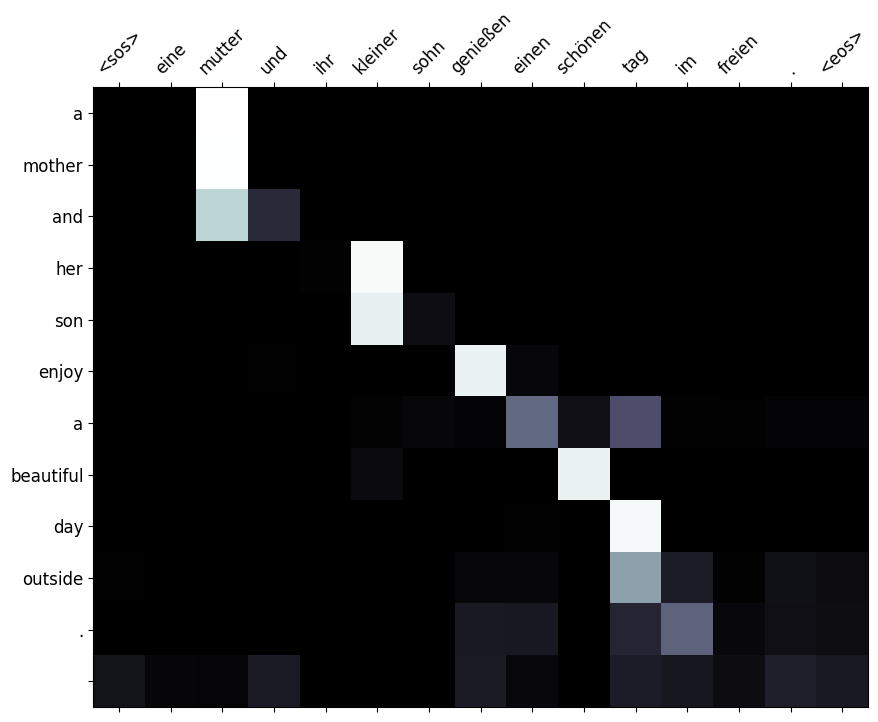

In [112]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):
    # 그래프 크기 설정
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)

    # 어텐션 데이터 (일반적으로 마지막 레이어의 어텐션을 시각화)
    # attention shape: [n_heads, trg_len, src_len]
    # 여기서는 첫 번째 헤드의 어텐션만 가져와서 시각화합니다.
    attention = attention.squeeze(0)[0].cpu().detach().numpy()

    # 행렬 시각화
    cax = ax.matshow(attention, cmap='bone')

    # 축 설정
    ax.tick_params(labelsize=12)

    # 소스 문장(독일어)을 x축에, 결과 문장(영어)을 y축에 배치
    # 입력 문장이 문자열인 경우 토큰화 진행
    if isinstance(sentence, str):
        src_tokens = ['<sos>'] + tokenize_de(sentence) + ['<eos>']
    else:
        src_tokens = ['<sos>'] + [token.lower() for token in sentence] + ['<eos>']

    ax.set_xticklabels([''] + src_tokens, rotation=45)
    ax.set_yticklabels([''] + translation)

    # 틱 간격 설정
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()
display_attention(src, translation, attention)

#### <b>BLEU Score 계산</b>

* 학습된 트랜스포머(Transformer) 모델의 BLEU 스코어 계산

In [113]:
from torchtext.data.metrics import bleu_score

def calculate_bleu_fixed(data, src_vocab, trg_vocab, model, device, max_len=50):
    trgs = []
    pred_trgs = []

    # 슬라이싱된 데이터가 딕셔너리 형태일 경우를 위해 길이를 측정합니다.
    num_samples = len(data['de']) if isinstance(data, dict) and 'de' in data else len(data)

    for i in range(num_samples):
        # 데이터가 딕셔너리(슬라이싱 결과)인지 개별 샘플 리스트인지 판별하여 접근
        if isinstance(data, dict):
            src = data['de'][i]
            trg = data['en'][i]
        else:
            src = data[i]['de']
            trg = data[i]['en']

        # 모델을 통해 번역 수행
        prediction, _ = translate_sentence(src, src_vocab, trg_vocab, model, device, max_len)

        # <eos> 토큰 제거 (itos에 따른 처리)
        if '<eos>' in prediction:
            prediction = prediction[:prediction.index('<eos>')]

        pred_trgs.append(prediction)

        # 정답 문장 토큰화 (리스트의 리스트 형태)
        trgs.append([tokenize_en(trg)])

    # BLEU 점수 계산
    score = bleu_score(pred_trgs, trgs)
    return score

# 실행 (test_dataset[:100] 슬라이싱을 그대로 사용해도 이제 안전합니다)
bleu_result = calculate_bleu_fixed(test_dataset[:100], SRC_vocab, TRG_vocab, model, device)
print(f'나의 모델 BLEU 점수: {bleu_result * 100:.2f}')

나의 모델 BLEU 점수: 36.62
